In [5]:
import numpy as np
import scipy.fft as fft
import scipy.optimize
import matplotlib.pyplot as plt

In [59]:
# Setting up the signal
F_s =1e6
T = 1/F_s
f_0 = 1e5
omega_0 = 2*np.pi*f_0
phi = np.pi/8
A = 1

N = 513
n_0 = -256
t = np.arange(n_0, n_0+N)*T

SNR_db = np.arange(-10, 70, 10)
SNR_num = 10**(SNR_db/10)

ks = np.arange(10,22,2)
M = 2**ks

#1a)
omega_vars = np.zeros((len(SNR_db), len(M)))
phi_vars = np.zeros((len(SNR_db), len(M)))

for i, SNR in enumerate(SNR_num):
    for j, m in enumerate(M):
        temp_omega = np.zeros(100)
        temp_phi = np.zeros(100)
        for k in range(100):
            noise_real = np.random.normal(0, np.sqrt(A**2/(2*SNR)), N)
            noise_complex = np.random.normal(0, np.sqrt(A**2/(2*SNR)), N)*1j
            signal = A*np.exp(1j*(omega_0*t+phi)) + noise_real+ noise_complex
            F = fft.fft(signal, n=m, norm='ortho')
            m_star = np.argmax(np.abs(F))
            omega_hat = 2*np.pi*m_star/(m*T)
            phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F[m_star])
            temp_omega[k] = omega_hat- omega_0
            temp_phi[k] = phi_hat - phi # Fixes wrapping
        print('SNR: ', SNR_db[i], 'M: ', m, 'omega: ', np.var(temp_omega, ddof=1), 'phi: ', np.var(temp_phi, ddof=1))
        omega_vars[i,j] = np.var(temp_omega, ddof=1)
        phi_vars[i,j] = np.var(temp_phi, ddof=1)
        

SNR:  -10 M:  1024 omega:  6084776.229759328 phi:  0.013573011388785167
SNR:  -10 M:  4096 omega:  659817.9224144305 phi:  0.01112495394919467
SNR:  -10 M:  16384 omega:  486945.5078986002 phi:  0.009511582842897756
SNR:  -10 M:  65536 omega:  583939.2698606511 phi:  0.011631562441690025
SNR:  -10 M:  262144 omega:  475803.9498607475 phi:  0.011134866310434423
SNR:  -10 M:  1048576 omega:  382867.0787048071 phi:  0.008347512593528226
SNR:  0 M:  1024 omega:  0.0 phi:  0.0011195458355434196
SNR:  0 M:  4096 omega:  489396.6506668782 phi:  0.001031449093991196
SNR:  0 M:  16384 omega:  58768.004797192705 phi:  0.0009896093569639075
SNR:  0 M:  65536 omega:  48982.00298723862 phi:  0.0007502765313593758
SNR:  0 M:  262144 omega:  52766.65098323333 phi:  0.0008487616131770524
SNR:  0 M:  1048576 omega:  46867.293926026265 phi:  0.001091487724670846
SNR:  10 M:  1024 omega:  0.0 phi:  0.00011392884646688335
SNR:  10 M:  4096 omega:  23530.970576017953 phi:  0.00010400566312469809
SNR:  10 M

513


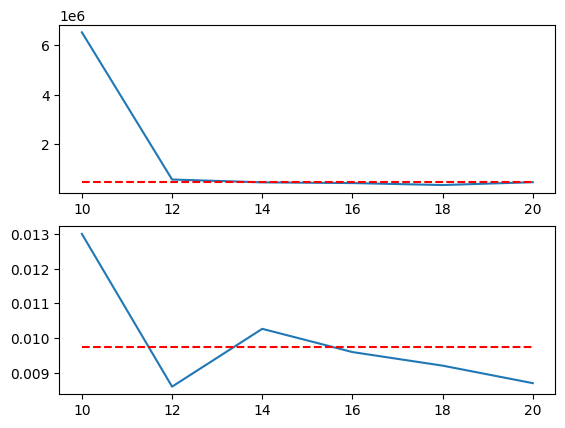

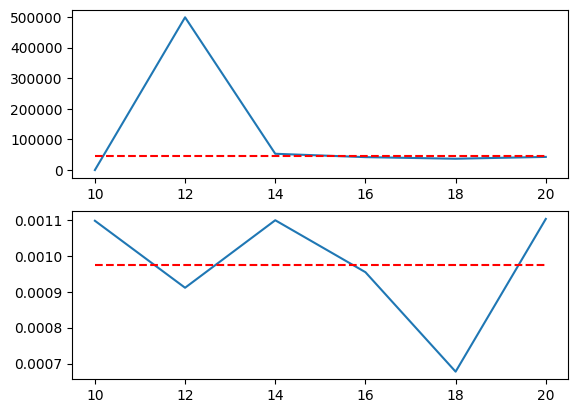

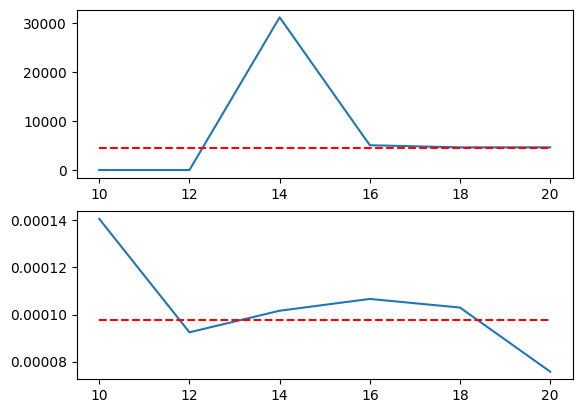

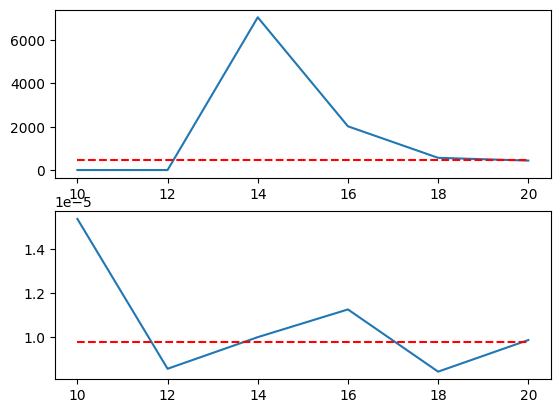

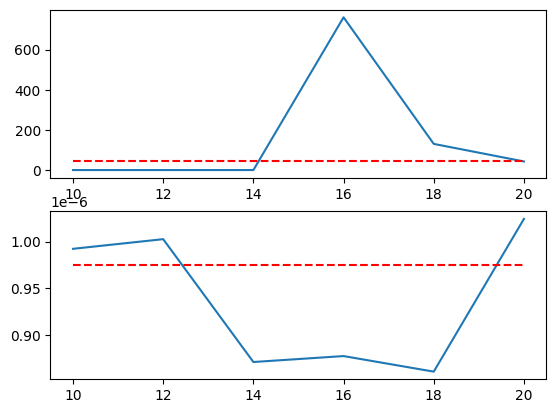

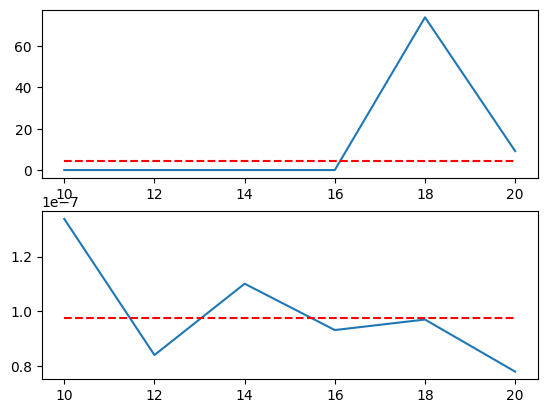

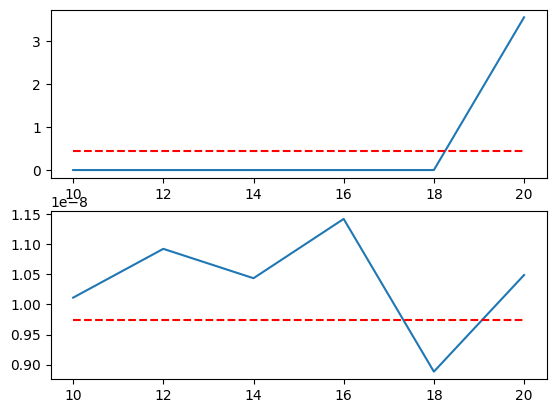

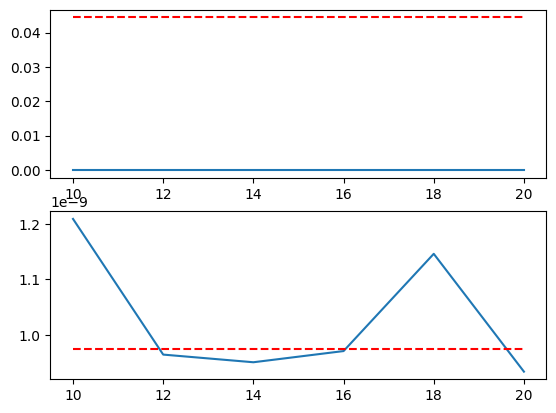

In [58]:
# Plotting
print(N)
crlb_omega = 12*(1/(2*SNR_num))/(T**2*N*(N+1)*(N-1))

P = N*(N-1)/2
Q = N*(N-1)*(2*N-1)/6

crlb_phi = (12*(1/(2*SNR_num))*(n_0**2*N+2*n_0*P+Q))/(N**2*(N-1)*(N+1))
for i, db in enumerate(SNR_db):
    plt.figure()
    plt.subplot(211)
    plt.plot(ks, omega_vars[i,:])
    plt.plot(ks, crlb_omega[i]*np.ones(len(ks)), 'r--')
    plt.subplot(212)
    plt.plot(ks, phi_vars[i,:])
    plt.plot(ks, crlb_phi[i]*np.ones(len(ks)), 'r--')

In [28]:
# 1b)

m = 2**10

def objective(omega, signal):
    n = np.arange(N)
    return -np.abs((1/N)*np.sum(signal*np.exp(-1j*omega*n*T)))

def F_func(omega, signal):
    n = np.arange(N)
    return (1/N)*np.sum(signal*np.exp(-1j*omega*n*T))

for i, SNR in enumerate(SNR_num):
    temp_omega = np.zeros(1000)
    temp_phi = np.zeros(1000)

    noise_real = np.random.normal(0, A**2/(2*SNR), N)
    noise_complex = np.random.normal(0, A**2/(2*SNR), N)*1j
    signal = A*np.exp(1j*(omega_0*t+phi)) + noise_real+ noise_complex
    F = fft.fft(signal, n=m, norm='ortho')
    m_star = np.argmax(np.abs(F))
    omega_hat = 2*np.pi*m_star/(m*T)
    phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F[m_star])
    res = scipy.optimize.minimize(objective, omega_hat, args=( signal),method='Nelder-Mead')
    omega_hat_new = res.x[0]
    phi_hat_new = np.angle(np.exp(-1j*omega_hat_new*n_0*T)*F_func(omega_hat_new, signal))

    
    print(omega_hat)
    print(res.x)
    print(omega_0)
    print(f"Estimate: {phi_hat_new}")
    print(f"Real value: {phi}")
        

5442563.835418255
[5444600.2076619]
628318.5307179586
Estimate: -0.39827041897033844
Real value: 0.39269908169872414
625864.1614573416
[628536.39946507]
628318.5307179586
Estimate: 0.3991332618305453
Real value: 0.39269908169872414
625864.1614573416
[628330.94373101]
628318.5307179586
Estimate: 0.3931162179189205
Real value: 0.39269908169872414
625864.1614573416
[628316.97626007]
628318.5307179586
Estimate: 0.39234935731495885
Real value: 0.39269908169872414
625864.1614573416
[628318.29205659]
628318.5307179586
Estimate: 0.3926730747106249
Real value: 0.39269908169872414
625864.1614573416
[628318.5520217]
628318.5307179586
Estimate: 0.39270019891581537
Real value: 0.39269908169872414
625864.1614573416
[628318.53115455]
628318.5307179586
Estimate: 0.39269894840968245
Real value: 0.39269908169872414


function